Packages

In [31]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()
from statsmodels.tsa.api import VAR

Loading data

In [2]:
data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "2000-01-03", 
                              end = "2020-03-02", interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 downloaded


In [3]:
dataframe = data.copy()

In [4]:
dataframe['spx'] = dataframe['^GSPC'].Close[:]
dataframe['dax'] = dataframe['^GDAXI'].Close[:]
dataframe['ftse'] = dataframe['^FTSE'].Close[:]
dataframe['nikkei'] = dataframe['^N225'].Close[:]

In [5]:
dataframe = dataframe.iloc[1:]
del dataframe['^N225']
del dataframe['^GSPC']
del dataframe['^GDAXI']
del dataframe['^FTSE']
dataframe = dataframe.asfreq('b')
dataframe = dataframe.fillna(method='ffill')

In [6]:
dataframe['ret_spx'] = dataframe.spx.pct_change(1).mul(100)
dataframe['ret_ftse'] = dataframe.ftse.pct_change(1).mul(100)
dataframe['ret_dax'] = dataframe.dax.pct_change(1).mul(100)
dataframe['ret_nikkei'] = dataframe.nikkei.pct_change(1).mul(100)

In [7]:
size = int(len(dataframe)*0.8)
df_train, df_test = dataframe.iloc[:size], dataframe.iloc[size:]

In [8]:
model_ar = ARIMA(df_train.spx, order = (1,0,0))
results_ar = model_ar.fit()

In [33]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = "2016-02-17"
end_date = "2017-01-09"
df_pred = results_ar.predict(start = start_date, end = end_date)

ARIMAX

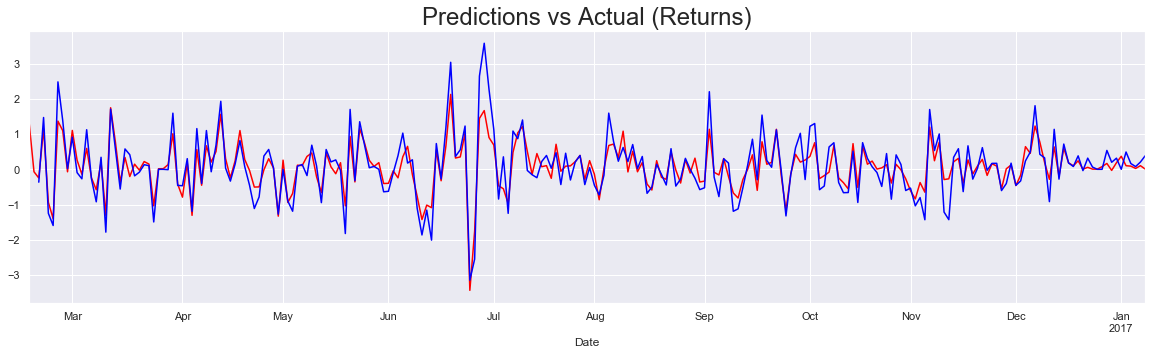

In [34]:
model_ret_armax = ARIMA(df_train.ret_spx[1:], exog = df_train[["ret_ftse","ret_dax","ret_nikkei"]][1:], order = (1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ret_ftse","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

SARIMAX

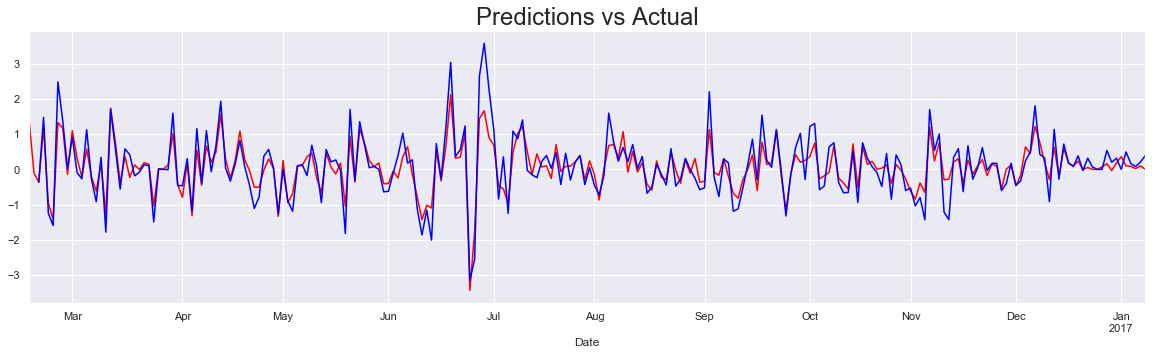

In [11]:
end_date = "2017-01-09"
model_ret_sarimax = SARIMAX(df_train.ret_spx[1:], exog = df_train[["ret_ftse","ret_dax","ret_nikkei"]][1:], 
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test[["ret_ftse","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

Auto ARIMA

In [12]:
model_auto = auto_arima(df_train.ret_spx[1:], exogenous = df_train[['ret_ftse', 'ret_dax', 'ret_nikkei']][1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [13]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[['ret_ftse', 'ret_dax', 'ret_nikkei']][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

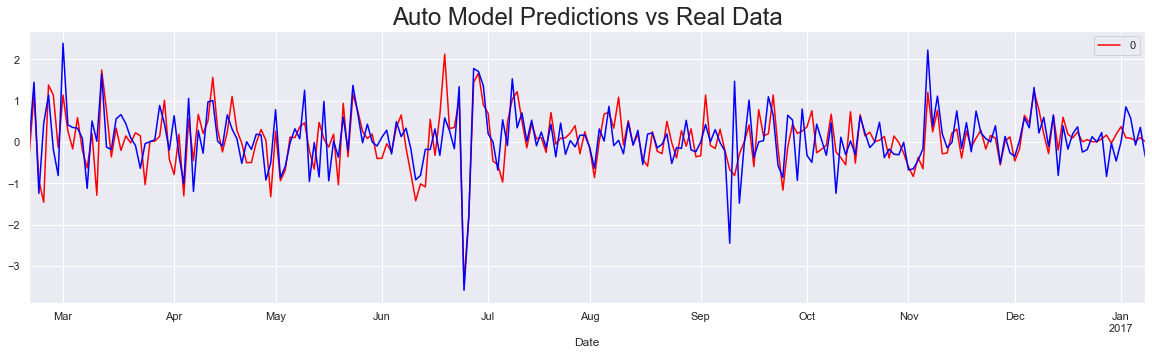

In [14]:
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.ret_spx[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

All Models

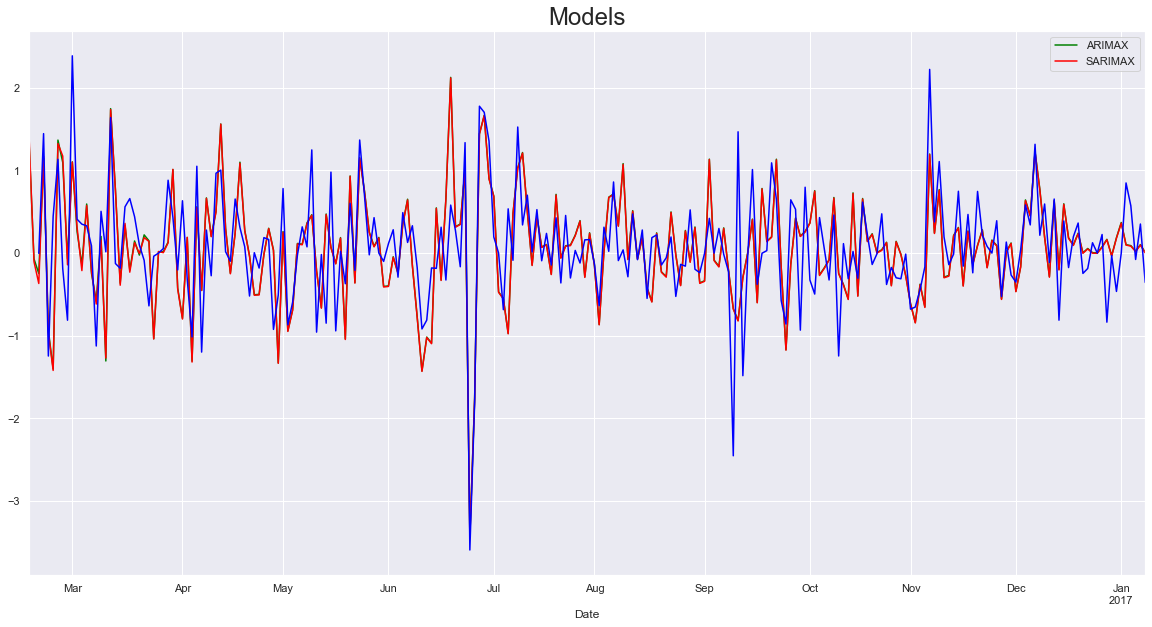

In [32]:
end_date = "2017-01-09"
df_pred_armax[start_date:end_date].plot(figsize = (20,10), color = "green")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_spx[start_date:end_date].plot(figsize = (20,10), color = "blue")
plt.legend(['ARIMAX','SARIMAX'])
plt.title("Models", size = 24)
plt.show()
#SARIMAX is the best, 2nd is the ARMAX
#ARMAX over shots during small spikes in price;but accurately predicts large spikes in prices
#SARIMAX behavessimilar to ARMAX but more stable

Forecasting Volatility

In [35]:
garch = arch_model(dataframe.ret_spx[1:], vol = "GARCH", p = 2, q = 1, mean = "constant", dist = "Normal")
res_garch = garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     83,   Neg. LLF: 5924.754649911428
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5924.740240064562
            Iterations: 13
            Function evaluations: 104
            Gradient evaluations: 13


In [38]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')
#horizon=how many obsevations we want our model to predict for each date
#for each date,we'll get the predicted value, for the next date
#align=determines whether we match the value with the date is made on, or the one it's supposed to represent

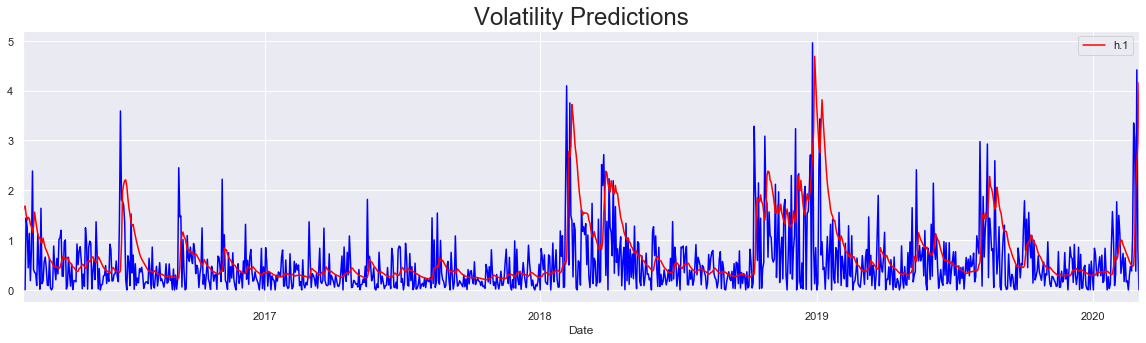

In [39]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_spx.abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()
#garch model under-forecasts volatility; however only when market is less volatile
#It does Slightly well when forecasting high volatility